<a href="https://colab.research.google.com/github/Sridipta-Roy/Protein-Function-Prediction/blob/main/04_EvaluationMetrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive

# Mount drive and navigate to project
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/protein-multimodal')


Mounted at /content/drive


In [ ]:
!pip install -q transformers accelerate peft bitsandbytes
!pip install -q rouge-score bert-score sacrebleu
!pip install -q nltk scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 45.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.9 MB/s eta 0:00:00


In [ ]:
PROJECT_ROOT = "/content/drive/MyDrive/protein-multimodal"
DATA_DIR = f"{PROJECT_ROOT}/data"
NEW_DATA_DIR = f"{DATA_DIR}/new_proteins_100"
EMB_DIR = f"{NEW_DATA_DIR}/embeddings"

MODELS_DIR = f"{PROJECT_ROOT}/models"
SAVE_DIR = f"{PROJECT_ROOT}/trained_mllm_v2.2"
RESULTS_DIR = f"{PROJECT_ROOT}/evaluation_results/Run_4_test"

os.makedirs(RESULTS_DIR, exist_ok=True)

In [ ]:
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from collections import defaultdict

from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# Evaluation metrics
from rouge_score import rouge_scorer
from bert_score import score as bert_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics.pairwise import cosine_similarity
import nltk

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🖥️  Device: {DEVICE}")
if DEVICE == "cuda":
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

🖥️  Device: cuda
   GPU: Tesla T4


### **Load model components**

In [ ]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(SAVE_DIR)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

In [ ]:
# Load base model with LoRA adapters
model = AutoModelForCausalLM.from_pretrained(
    SAVE_DIR,
    torch_dtype=torch.float32,
    device_map=DEVICE,
)
model.eval()

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): lora.Linear(
            (base_layer): Linear(in_features=2560, out_features=2560, bias=True)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=2560, out_features=16, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=16, out_features=2560, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (v_proj): lora.Linear(
            (base_layer): Linear(in_features=2560, out_features=2560, bias=True

In [ ]:
# Load protein projector
class ProteinProjector(nn.Module):
    def __init__(self, input_dim, output_dim=2560):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.GELU(),
            nn.Linear(2048, output_dim),
        )

    def forward(self, x):
        return self.mlp(x)

In [ ]:
# Determine embedding dimension
test_emb = torch.load(f"{EMB_DIR}/new_proteins_100_embeddings.pt", map_location="cpu")
emb_dim = test_emb.shape[1]
print(f"Embedding dimension: {emb_dim}")

Embedding dimension: 1280


In [ ]:
projector = ProteinProjector(input_dim=emb_dim).to(DEVICE)
projector.load_state_dict(torch.load(f"{SAVE_DIR}/protein_projector.pt", map_location=DEVICE))
projector.eval()

print("Model loaded successfully")

Model loaded successfully


### **Load TEST DATA**

In [ ]:
with open(f"{EMB_DIR}/new_proteins_100_metadata.json", "r") as f:
    test_metadata = json.load(f)

test_embeddings = torch.load(f"{EMB_DIR}/new_proteins_100_embeddings.pt", map_location="cpu")

print(f"Test samples: {len(test_metadata)}")
print(f"Embeddings shape: {test_embeddings.shape}")

Test samples: 100
Embeddings shape: torch.Size([100, 1280])


### **Inference**

In [ ]:
# def build_prompt_for_sequence(seq: str) -> str:
#     """Build prompt matching training format"""
#     seq = seq.strip()
#     return (
#         "[PROTEIN]\n"
#         f"LENGTH: {len(seq)}\n"
#         f"SEQUENCE: {seq}\n"
#         "[/PROTEIN]\n"
#         "FUNCTION:\n"
#     )

In [ ]:
def build_prompt_for_sequence(seq, go_terms=None, ec_numbers=None):
    prompt = "[PROTEIN]\n"
    prompt += f"LENGTH: {len(seq)}\n"
    prompt += f"SEQUENCE: {seq[:50]}...(truncated)\n"

    # Only add if available
    if go_terms:
        go_str = ", ".join([g["go_term"] for g in go_terms[:5] if g["go_term"]])
        prompt += f"GO_TERMS: {go_str}\n"

    if ec_numbers:
        prompt += f"EC_NUMBERS: {', '.join(ec_numbers)}\n"

    prompt += "[/PROTEIN]\nFUNCTION:\n"
    return prompt

In [ ]:
@torch.no_grad()
def generate_function_prediction(protein_embedding, sequence, max_new_tokens=256):
    """
    Generate function prediction for a single protein

    Args:
        protein_embedding: (D,) tensor - ESM embedding
        sequence: str - amino acid sequence
        max_new_tokens: int - maximum tokens to generate

    Returns:
        predicted_text: str - generated function description
    """
    model.eval()
    projector.eval()

    # Prepare prompt
    prompt = build_prompt_for_sequence(sequence)

    # Tokenize prompt
    encoded = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=256,
    ).to(DEVICE)

    input_ids = encoded["input_ids"]  # (1, T)

    # Project protein embedding to prefix token
    protein_emb = protein_embedding.unsqueeze(0).to(DEVICE).to(model.dtype)  # (1, D)
    prefix_token = projector(protein_emb).unsqueeze(1)  # (1, 1, D_llm)

    # Get token embeddings
    token_embeds = model.get_input_embeddings()(input_ids)  # (1, T, D_llm)

    # Concatenate prefix with token embeddings
    inputs_embeds = torch.cat([prefix_token, token_embeds], dim=1)  # (1, T+1, D_llm)

    # Create attention mask (prefix is visible)
    attention_mask = torch.ones((1, inputs_embeds.shape[1]), dtype=torch.long, device=DEVICE)

    # Generate
    with torch.amp.autocast("cuda", dtype=torch.float16, enabled=(DEVICE=="cuda")):
        outputs = model.generate(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,
            do_sample=False,  # Greedy decoding for reproducibility
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    # Decode generated text
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract only the generated part (after FUNCTION:)
    if "FUNCTION:" in generated_text:
        predicted_function = generated_text.split("FUNCTION:")[-1].strip()
    else:
        predicted_function = generated_text.strip()

    return predicted_function

### **Evaluation**

In [ ]:
class ProteinFunctionEvaluator:
    """Comprehensive evaluation metrics for protein function prediction"""

    def __init__(self):
        self.rouge_scorer = rouge_scorer.RougeScorer(
            ['rouge1', 'rouge2', 'rougeL'],
            use_stemmer=True
        )
        self.smoothing = SmoothingFunction().method1

    def compute_rouge(self, prediction, reference):
        """Compute ROUGE scores (recall-oriented, good for summarization)"""
        scores = self.rouge_scorer.score(reference, prediction)
        return {
            'rouge1_f': scores['rouge1'].fmeasure,
            'rouge1_p': scores['rouge1'].precision,
            'rouge1_r': scores['rouge1'].recall,
            'rouge2_f': scores['rouge2'].fmeasure,
            'rouge2_p': scores['rouge2'].precision,
            'rouge2_r': scores['rouge2'].recall,
            'rougeL_f': scores['rougeL'].fmeasure,
            'rougeL_p': scores['rougeL'].precision,
            'rougeL_r': scores['rougeL'].recall,
        }

    def compute_bleu(self, prediction, reference):
        """Compute BLEU scores (precision-oriented, good for machine translation)"""
        reference_tokens = nltk.word_tokenize(reference.lower())
        prediction_tokens = nltk.word_tokenize(prediction.lower())

        bleu1 = sentence_bleu([reference_tokens], prediction_tokens,
                             weights=(1, 0, 0, 0),
                             smoothing_function=self.smoothing)
        bleu2 = sentence_bleu([reference_tokens], prediction_tokens,
                             weights=(0.5, 0.5, 0, 0),
                             smoothing_function=self.smoothing)
        bleu4 = sentence_bleu([reference_tokens], prediction_tokens,
                             weights=(0.25, 0.25, 0.25, 0.25),
                             smoothing_function=self.smoothing)

        return {
            'bleu1': bleu1,
            'bleu2': bleu2,
            'bleu4': bleu4,
        }

    def compute_semantic_similarity(self, prediction, reference):
        """
        Compute semantic similarity using simple embedding-based approach
        Note: For production, consider using BERTScore or sentence-transformers
        """
        # Simple word overlap-based similarity
        pred_words = set(prediction.lower().split())
        ref_words = set(reference.lower().split())

        if len(pred_words) == 0 or len(ref_words) == 0:
            return 0.0

        intersection = len(pred_words & ref_words)
        union = len(pred_words | ref_words)

        jaccard = intersection / union if union > 0 else 0.0

        return jaccard

    def compute_length_metrics(self, prediction, reference):
        """Compute length-based metrics"""
        pred_len = len(prediction.split())
        ref_len = len(reference.split())

        length_ratio = pred_len / ref_len if ref_len > 0 else 0.0
        length_diff = abs(pred_len - ref_len)

        return {
            'pred_length': pred_len,
            'ref_length': ref_len,
            'length_ratio': length_ratio,
            'length_diff': length_diff,
        }

    def evaluate_single(self, prediction, reference):
        """Compute all metrics for a single prediction"""
        metrics = {}

        # ROUGE scores
        rouge_scores = self.compute_rouge(prediction, reference)
        metrics.update(rouge_scores)

        # BLEU scores
        bleu_scores = self.compute_bleu(prediction, reference)
        metrics.update(bleu_scores)

        # Semantic similarity
        metrics['jaccard_similarity'] = self.compute_semantic_similarity(prediction, reference)

        # Length metrics
        length_metrics = self.compute_length_metrics(prediction, reference)
        metrics.update(length_metrics)

        return metrics

    def aggregate_metrics(self, all_metrics):
        """Aggregate metrics across all samples"""
        aggregated = defaultdict(list)

        for metrics in all_metrics:
            for key, value in metrics.items():
                aggregated[key].append(value)

        summary = {}
        for key, values in aggregated.items():
            summary[f'{key}_mean'] = np.mean(values)
            summary[f'{key}_std'] = np.std(values)
            summary[f'{key}_median'] = np.median(values)

        return summary


### **BERT Score Computation**

In [ ]:
def compute_bertscore_batch(predictions, references, batch_size=32):
    """
    Compute BERTScore for all predictions
    This is done separately as it's computationally expensive
    """
    print("\n📊 Computing BERTScore ...")

    all_P = []
    all_R = []
    all_F1 = []

    # Process in batches
    for i in tqdm(range(0, len(predictions), batch_size), desc="BERTScore"):
        batch_preds = predictions[i:i+batch_size]
        batch_refs = references[i:i+batch_size]

        P, R, F1 = bert_score(
            batch_preds,
            batch_refs,
            lang="en",
            verbose=False,
            device=DEVICE
        )

        all_P.extend(P.cpu().numpy().tolist())
        all_R.extend(R.cpu().numpy().tolist())
        all_F1.extend(F1.cpu().numpy().tolist())

    return {
        'bertscore_precision': all_P,
        'bertscore_recall': all_R,
        'bertscore_f1': all_F1,
    }


### **Run Evaluation**

In [ ]:
evaluator = ProteinFunctionEvaluator()
results = []

# Limit evaluation to first N samples for speed (remove limit for full evaluation)
EVAL_LIMIT = None  # Set to None to evaluate all, or e.g., 100 for quick test
eval_samples = test_metadata[:EVAL_LIMIT] if EVAL_LIMIT else test_metadata
eval_embeddings = test_embeddings[:EVAL_LIMIT] if EVAL_LIMIT else test_embeddings

print(f"Evaluating on {len(eval_samples)} samples...\n")

Evaluating on 100 samples...



In [ ]:
# # ============================================================================
# # FILTER BY SEQUENCE LENGTH
# # ============================================================================

# MAX_SEQUENCE_LENGTH = 100  # Set to None to evaluate all sequences

# # Filter samples by sequence length
# if MAX_SEQUENCE_LENGTH is not None:
#     print(f"\n🔍 Filtering for sequences with length ≤ {MAX_SEQUENCE_LENGTH}...")

#     filtered_indices = [
#         i for i, sample in enumerate(test_metadata)
#         if sample['length'] <= MAX_SEQUENCE_LENGTH
#     ]

#     eval_samples = [test_metadata[i] for i in filtered_indices]
#     eval_embeddings = test_embeddings[filtered_indices]

#     print(f"   Original test set: {len(test_metadata)} samples")
#     print(f"   Filtered test set: {len(eval_samples)} samples ({len(eval_samples)/len(test_metadata)*100:.1f}%)")
#     print(f"   Average length: {np.mean([s['length'] for s in eval_samples]):.1f} amino acids")
#     print(f"   Length range: {min(s['length'] for s in eval_samples)} - {max(s['length'] for s in eval_samples)}")
# else:
#     eval_samples = test_metadata
#     eval_embeddings = test_embeddings
#     print(f"\n📊 Evaluating on full test set: {len(eval_samples)} samples")

# # Additional limit for quick testing (optional)
# EVAL_LIMIT = None  # Set to e.g., 50 for quick test, None for all filtered samples
# if EVAL_LIMIT is not None and EVAL_LIMIT < len(eval_samples):
#     print(f"\n⚠️  Quick test mode: Limiting to first {EVAL_LIMIT} samples")
#     eval_samples = eval_samples[:EVAL_LIMIT]
#     eval_embeddings = eval_embeddings[:EVAL_LIMIT]

# print(f"\n🎯 Final evaluation set: {len(eval_samples)} samples\n")

In [ ]:
import nltk

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)
print("✅ NLTK data downloaded")

✅ NLTK data downloaded


In [ ]:
for idx in tqdm(range(len(eval_samples)), desc="Generating predictions"):
    sample = eval_samples[idx]
    embedding = eval_embeddings[idx]

    # Generate prediction
    try:
        prediction = generate_function_prediction(
            embedding,
            sample['sequence'],
            max_new_tokens=256
        )
    except Exception as e:
        print(f"\n⚠️  Error generating prediction for sample {idx}: {e}")
        prediction = ""

    # Get ground truth
    ground_truth = sample['function']

    # Compute metrics
    metrics = evaluator.evaluate_single(prediction, ground_truth)

    # Store results
    result = {
        'index': idx,
        'accession': sample['accession'],
        'protein_name': sample.get('protein_name', ''),
        'sequence': sample['sequence'][:60] + "...",  # Truncate for readability
        'sequence_length': sample['length'],
        'ground_truth': ground_truth,
        'prediction': prediction,
    }
    result.update(metrics)
    results.append(result)

# Convert to DataFrame
results_df = pd.DataFrame(results)

print("\n✅ Predictions generated successfully")

Generating predictions:   0%|          | 0/100 [00:00<?, ?it/s]


✅ Predictions generated successfully


In [ ]:
# ============================================================================
# COMPUTE BERTSCORE
# ============================================================================

predictions_list = results_df['prediction'].tolist()
references_list = results_df['ground_truth'].tolist()

bertscore_results = compute_bertscore_batch(predictions_list, references_list)

# Add BERTScore to results
results_df['bertscore_precision'] = bertscore_results['bertscore_precision']
results_df['bertscore_recall'] = bertscore_results['bertscore_recall']
results_df['bertscore_f1'] = bertscore_results['bertscore_f1']


📊 Computing BERTScore ...


BERTScore:   0%|          | 0/4 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You sho

In [ ]:
# ============================================================================
# AGGREGATE RESULTS AND SUMMARY STATISTICS
# ============================================================================

print("\n📈 Computing aggregate metrics...")

# Metrics to aggregate
metric_columns = [
    'rouge1_f', 'rouge2_f', 'rougeL_f',
    'bleu1', 'bleu2', 'bleu4',
    'jaccard_similarity',
    'bertscore_precision', 'bertscore_recall', 'bertscore_f1',
    'length_ratio', 'length_diff'
]

# Compute summary statistics
summary_stats = {}
for metric in metric_columns:
    if metric in results_df.columns:
        summary_stats[f'{metric}_mean'] = results_df[metric].mean()
        summary_stats[f'{metric}_std'] = results_df[metric].std()
        summary_stats[f'{metric}_median'] = results_df[metric].median()
        summary_stats[f'{metric}_min'] = results_df[metric].min()
        summary_stats[f'{metric}_max'] = results_df[metric].max()

# Create summary DataFrame
summary_df = pd.DataFrame([summary_stats])


📈 Computing aggregate metrics...


In [ ]:
# ============================================================================
# DISPLAY RESULTS
# ============================================================================

print("\n" + "="*80)
print("📊 EVALUATION RESULTS SUMMARY")
print("="*80)

print("\n🎯 PRIMARY METRICS:")
print(f"  ROUGE-1 F1:        {summary_stats['rouge1_f_mean']:.4f} ± {summary_stats['rouge1_f_std']:.4f}")
print(f"  ROUGE-2 F1:        {summary_stats['rouge2_f_mean']:.4f} ± {summary_stats['rouge2_f_std']:.4f}")
print(f"  ROUGE-L F1:        {summary_stats['rougeL_f_mean']:.4f} ± {summary_stats['rougeL_f_std']:.4f}")
print(f"  BLEU-1:            {summary_stats['bleu1_mean']:.4f} ± {summary_stats['bleu1_std']:.4f}")
print(f"  BLEU-4:            {summary_stats['bleu4_mean']:.4f} ± {summary_stats['bleu4_std']:.4f}")
print(f"  BERTScore F1:      {summary_stats['bertscore_f1_mean']:.4f} ± {summary_stats['bertscore_f1_std']:.4f}")
print(f"  Jaccard Similarity: {summary_stats['jaccard_similarity_mean']:.4f} ± {summary_stats['jaccard_similarity_std']:.4f}")

print("\n📏 LENGTH METRICS:")
print(f"  Avg Pred Length:   {results_df['pred_length'].mean():.1f} words")
print(f"  Avg Ref Length:    {results_df['ref_length'].mean():.1f} words")
print(f"  Length Ratio:      {summary_stats['length_ratio_mean']:.4f} ± {summary_stats['length_ratio_std']:.4f}")



📊 EVALUATION RESULTS SUMMARY

🎯 PRIMARY METRICS:
  ROUGE-1 F1:        0.2019 ± 0.1680
  ROUGE-2 F1:        0.0636 ± 0.1798
  ROUGE-L F1:        0.1544 ± 0.1663
  BLEU-1:            0.1779 ± 0.1724
  BLEU-4:            0.0483 ± 0.1735
  BERTScore F1:      0.8295 ± 0.0379
  Jaccard Similarity: 0.1194 ± 0.1667

📏 LENGTH METRICS:
  Avg Pred Length:   46.3 words
  Avg Ref Length:    31.2 words
  Length Ratio:      2.0159 ± 1.6785


### **Visualization**

In [ ]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

fig = plt.figure(figsize=(18, 12))

<Figure size 1800x1200 with 0 Axes>

/tmp/ipython-input-3331671564.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = results_df.groupby('length_bin')[['rouge1_f', 'rouge2_f', 'rougeL_f', 'bertscore_f1']].mean()


✅ Saved visualization to /content/drive/MyDrive/protein-multimodal/evaluation_results/Run_4_test/evaluation_metrics_visualization.png


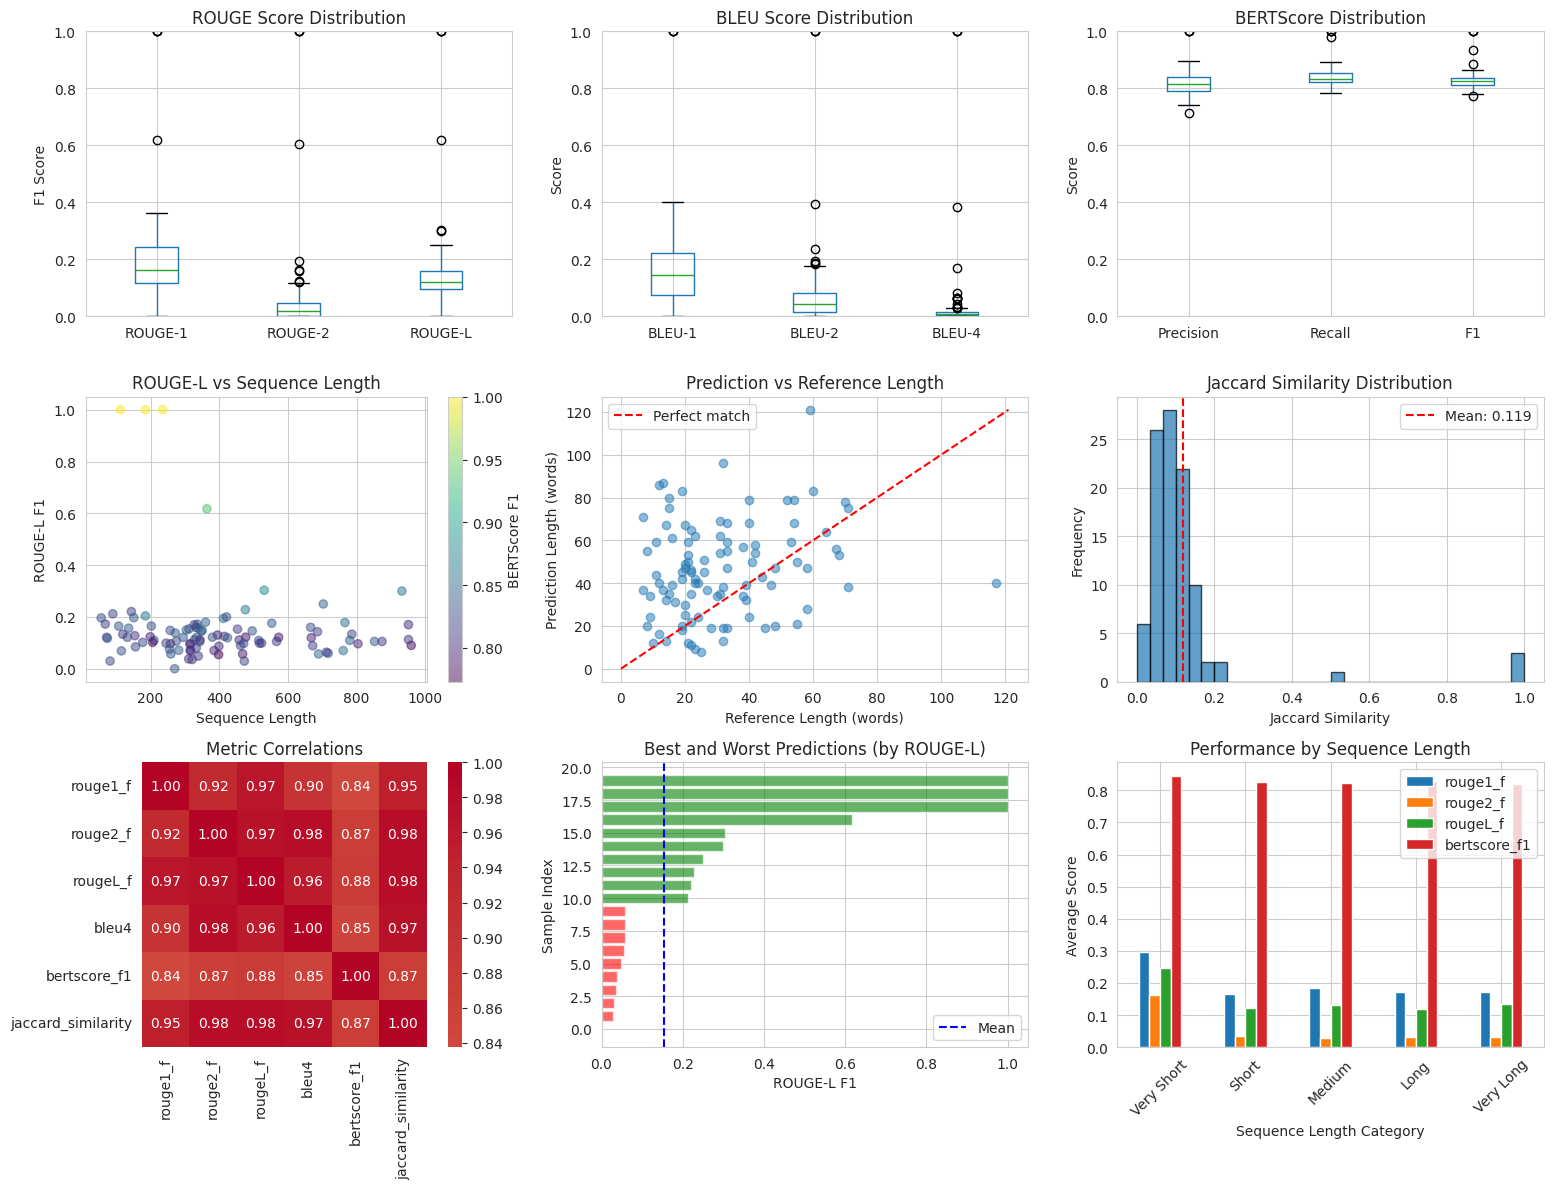

In [ ]:
# 1. ROUGE scores distribution
ax1 = plt.subplot(3, 3, 1)
rouge_data = results_df[['rouge1_f', 'rouge2_f', 'rougeL_f']]
rouge_data.columns = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
rouge_data.boxplot(ax=ax1)
ax1.set_ylabel('F1 Score')
ax1.set_title('ROUGE Score Distribution')
ax1.set_ylim([0, 1])

# 2. BLEU scores distribution
ax2 = plt.subplot(3, 3, 2)
bleu_data = results_df[['bleu1', 'bleu2', 'bleu4']]
bleu_data.columns = ['BLEU-1', 'BLEU-2', 'BLEU-4']
bleu_data.boxplot(ax=ax2)
ax2.set_ylabel('Score')
ax2.set_title('BLEU Score Distribution')
ax2.set_ylim([0, 1])

# 3. BERTScore distribution
ax3 = plt.subplot(3, 3, 3)
bert_data = results_df[['bertscore_precision', 'bertscore_recall', 'bertscore_f1']]
bert_data.columns = ['Precision', 'Recall', 'F1']
bert_data.boxplot(ax=ax3)
ax3.set_ylabel('Score')
ax3.set_title('BERTScore Distribution')
ax3.set_ylim([0, 1])

# 4. ROUGE-L vs Sequence Length
ax4 = plt.subplot(3, 3, 4)
scatter = ax4.scatter(results_df['sequence_length'], results_df['rougeL_f'],
                     alpha=0.5, c=results_df['bertscore_f1'], cmap='viridis')
ax4.set_xlabel('Sequence Length')
ax4.set_ylabel('ROUGE-L F1')
ax4.set_title('ROUGE-L vs Sequence Length')
plt.colorbar(scatter, ax=ax4, label='BERTScore F1')

# 5. Prediction length vs Reference length
ax5 = plt.subplot(3, 3, 5)
ax5.scatter(results_df['ref_length'], results_df['pred_length'], alpha=0.5)
max_len = max(results_df['ref_length'].max(), results_df['pred_length'].max())
ax5.plot([0, max_len], [0, max_len], 'r--', label='Perfect match')
ax5.set_xlabel('Reference Length (words)')
ax5.set_ylabel('Prediction Length (words)')
ax5.set_title('Prediction vs Reference Length')
ax5.legend()

# 6. Jaccard Similarity distribution
ax6 = plt.subplot(3, 3, 6)
ax6.hist(results_df['jaccard_similarity'], bins=30, edgecolor='black', alpha=0.7)
ax6.set_xlabel('Jaccard Similarity')
ax6.set_ylabel('Frequency')
ax6.set_title('Jaccard Similarity Distribution')
ax6.axvline(results_df['jaccard_similarity'].mean(), color='r',
           linestyle='--', label=f'Mean: {results_df["jaccard_similarity"].mean():.3f}')
ax6.legend()

# 7. Correlation heatmap
ax7 = plt.subplot(3, 3, 7)
corr_metrics = ['rouge1_f', 'rouge2_f', 'rougeL_f', 'bleu4',
                'bertscore_f1', 'jaccard_similarity']
corr_matrix = results_df[corr_metrics].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
           center=0, ax=ax7, square=True)
ax7.set_title('Metric Correlations')

# 8. Top 10 and Bottom 10 predictions by ROUGE-L
ax8 = plt.subplot(3, 3, 8)
sorted_df = results_df.sort_values('rougeL_f')
top_10 = sorted_df.tail(10)['rougeL_f']
bottom_10 = sorted_df.head(10)['rougeL_f']
combined = pd.concat([bottom_10, top_10])
colors = ['red']*10 + ['green']*10
ax8.barh(range(len(combined)), combined.values, color=colors, alpha=0.6)
ax8.set_xlabel('ROUGE-L F1')
ax8.set_ylabel('Sample Index')
ax8.set_title('Best and Worst Predictions (by ROUGE-L)')
ax8.axvline(results_df['rougeL_f'].mean(), color='blue',
           linestyle='--', label='Mean')
ax8.legend()

# 9. Performance by sequence length bins
ax9 = plt.subplot(3, 3, 9)
results_df['length_bin'] = pd.cut(results_df['sequence_length'],
                                   bins=5, labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'])
grouped = results_df.groupby('length_bin')[['rouge1_f', 'rouge2_f', 'rougeL_f', 'bertscore_f1']].mean()
grouped.plot(kind='bar', ax=ax9)
ax9.set_xlabel('Sequence Length Category')
ax9.set_ylabel('Average Score')
ax9.set_title('Performance by Sequence Length')
ax9.legend(loc='best')
ax9.set_xticklabels(ax9.get_xticklabels(), rotation=45)

plt.tight_layout()
viz_path = f"{RESULTS_DIR}/evaluation_metrics_visualization.png"
plt.savefig(viz_path, dpi=300, bbox_inches='tight')
print(f"✅ Saved visualization to {viz_path}")
plt.show()

In [ ]:
# ============================================================================
# QUALITATIVE ANALYSIS - SHOW EXAMPLES
# ============================================================================

print("\n" + "="*80)
print("📝 QUALITATIVE ANALYSIS - SAMPLE PREDICTIONS")
print("="*80)

# Best predictions
print("\n🏆 TOP 10 PREDICTIONS (by ROUGE-L):")
print("-" * 80)
top_10 = results_df.nlargest(10, 'rougeL_f')
for i, (idx, row) in enumerate(top_10.iterrows(), 1):
    print(f"\n{i}. Sample {row['index']} | {row['accession']} | ROUGE-L: {row['rougeL_f']:.4f}")
    print(f"   Protein: {row['protein_name']}")
    print(f"   Ground Truth: {row['ground_truth']}")
    print(f"   Prediction:   {row['prediction']}")

# Worst predictions
print("\n⚠️  BOTTOM 3 PREDICTIONS (by ROUGE-L):")
print("-" * 80)
bottom_3 = results_df.nsmallest(3, 'rougeL_f')
for i, (idx, row) in enumerate(bottom_3.iterrows(), 1):
    print(f"\n{i}. Sample {row['index']} | {row['accession']} | ROUGE-L: {row['rougeL_f']:.4f}")
    print(f"   Protein: {row['protein_name']}")
    print(f"   Ground Truth: {row['ground_truth']}")
    print(f"   Prediction:   {row['prediction']}")



📝 QUALITATIVE ANALYSIS - SAMPLE PREDICTIONS

🏆 TOP 10 PREDICTIONS (by ROUGE-L):
--------------------------------------------------------------------------------

1. Sample 26 | P01714 | ROUGE-L: 1.0000
   Protein: Immunoglobulin lambda variable 3-19
   Ground Truth: V region of the variable domain of immunoglobulin light chains that participates in the antigen recognition (PubMed:24600447). Immunoglobulins, also known as antibodies, are membrane-bound or secreted glycoproteins produced by B lymphocytes. In the recognition phase of humoral immunity, the membrane-bound immunoglobulins serve as receptors which, upon binding of a specific antigen, trigger the clonal expansion and differentiation of B lymphocytes into immunoglobulins-secreting plasma cells.
   Prediction:   V region of the variable domain of immunoglobulin light chains that participates in the antigen recognition (PubMed:24600447). Immunoglobulins, also known as antibodies, are membrane-bound or secreted glycoproteins prod

In [ ]:
print("\n💾 Saving results...")

# Save detailed results
results_path = f"{RESULTS_DIR}/detailed_results.csv"
results_df.to_csv(results_path, index=False)
print(f"✅ Saved detailed results to {results_path}")

# Save summary statistics
summary_path = f"{RESULTS_DIR}/summary_statistics.json"
with open(summary_path, 'w') as f:
    json.dump(summary_stats, f, indent=2)
print(f"✅ Saved summary statistics to {summary_path}")

# Save predictions for manual inspection
predictions_path = f"{RESULTS_DIR}/predictions.json"
predictions_export = results_df[['index', 'accession', 'protein_name',
                                 'ground_truth', 'prediction']].to_dict('records')
with open(predictions_path, 'w') as f:
    json.dump(predictions_export, f, indent=2)
print(f"✅ Saved predictions to {predictions_path}")


💾 Saving results...
✅ Saved detailed results to /content/drive/MyDrive/protein-multimodal/evaluation_results/Run_4_test/detailed_results.csv
✅ Saved summary statistics to /content/drive/MyDrive/protein-multimodal/evaluation_results/Run_4_test/summary_statistics.json
✅ Saved predictions to /content/drive/MyDrive/protein-multimodal/evaluation_results/Run_4_test/predictions.json
